In [11]:
import random
import math

import numpy as np
from numba import njit, prange

import pandas as pd

from matplotlib import pyplot as plt

In [12]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int, label:str):
    data = []

    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(r1, r2)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return {
        'features': np.array(data),
        'label': label
    }

def gen_circle_smaple(c: tuple, r: float, n: int, label: str):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return {
        'features': np.array(data),
        'label': label
    }

In [38]:
def F(x: np.ndarray) -> float:
    # return np.clip(x,-1, 1)
    return np.tanh(x)


def dF(x: np.ndarray) -> float:
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    return 1-np.square(np.tanh(x))


@njit()
def F_jit(x: np.ndarray) -> np.ndarray:
    # return np.clip(x,-1, 1)
    return np.tanh(x)


@njit()
def dF_jit(x: np.ndarray) -> np.ndarray:
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    return 1-np.square(np.tanh(x))


@njit()
def grads(xBatch: np.ndarray, w: np.ndarray, b:np.ndarray, l: float) -> tuple[np.ndarray]:
    n = xBatch.shape[0]
    nIn = w.shape[0]

    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)
    
    for i in prange(n):
        u = xBatch[i] @ w + b
        y = F_jit(u) @ w.T

        dEdy = 2/nIn * (y-xBatch[i])
        
        dw += (dEdy @ w) * dF_jit(u) * np.atleast_2d(xBatch[i]).T - l*2*w
        db += (dEdy @ w) * dF_jit(u)
    
    return (dw, db)

class RestrictedBoltzmannMachine:
    def __init__(self, nIn: int, nHidden: int, regularization: float) -> None:
        self.nIn = nIn
        self.nHidden = nHidden

        self.l = regularization
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (nIn, nHidden))
        self.b: np.ndarray = np.zeros(nHidden)


    def predict(self, x:np.ndarray) -> np.ndarray:
        return F(x @ self.w + self.b) @ self.w.T


    def train(self, xTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dw, db = grads(xTrain[idxs], self.w, self.b, self.l)
            
            self.w -= lr*dw
            self.b -= lr*db
        
    
    def loss(self, x: np.ndarray) -> float:
        Xpred = np.array([self.predict(xi) for xi in x])
        d = 1/self.nIn * np.sum(np.square(x-Xpred), axis=1)
        return 1/x.shape[0] * np.sum(d)

In [14]:
sample1 = gen_ring_sample((0,0), 1, 1.2, 300, 'A')

data = [sample1]

In [15]:
df = pd.DataFrame(columns=['x1', 'x2', 'label'])

for sample in data:
    for feature in sample['features']:
        df.loc[len(df.index)] = [*feature, sample['label']]

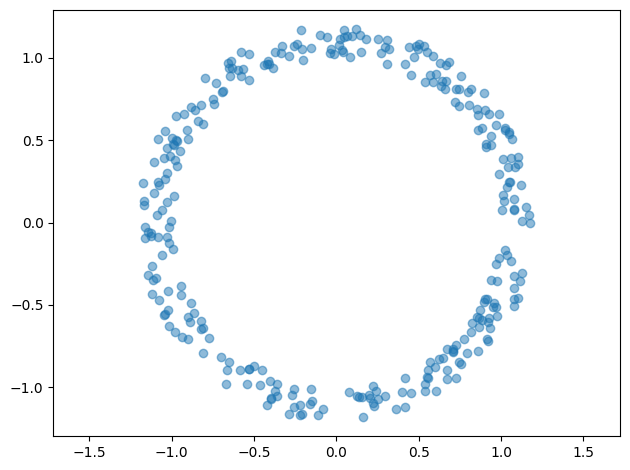

In [16]:
for label in df['label'].unique():
    plt.scatter(df[df['label'] == label]['x1'], df[df['label'] == label]['x2'], alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [17]:
test_frac = 0.8

p = np.random.permutation(df.index.size)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = p[0:test_size]
idx_train = p[test_size:p.size]

xTest = np.array(df.iloc[idx_test][['x1', 'x2']])

xTrain = np.array(df.iloc[idx_train][['x1', 'x2']])

In [63]:
nIn = 2
nHidden = 3

lr = 1e-2
regularization = 1e-6
batch_size = 20
max_iter = 3000

model = RestrictedBoltzmannMachine(nIn, nHidden, regularization)

print('untrained loss: {0:.6f}'.format(model.loss(xTest)))

model.train(xTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest)))

untrained loss: 0.811517
trained loss: 0.000233


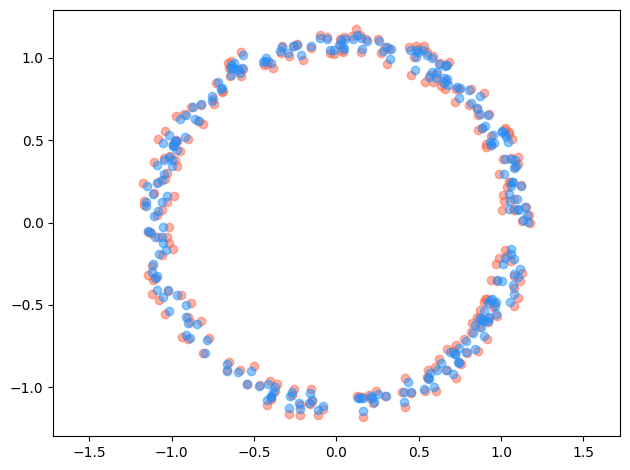

In [64]:
u = np.array([model.predict(x) for x in xTest])

plt.scatter(xTest[:,0], xTest[:,1], c='tomato', alpha=0.5)
plt.scatter(u[:,0], u[:,1], c='dodgerblue', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

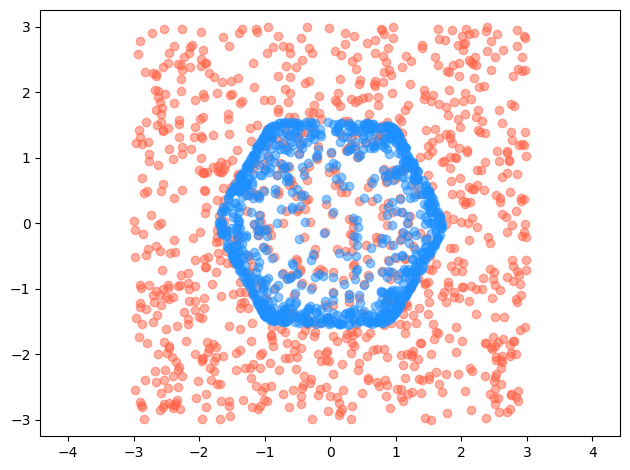

In [65]:
x = np.random.uniform(-3, 3, (1000, 2))

u = np.array([model.predict(xi) for xi in x])

plt.scatter(x[:,0], x[:,1], c='tomato', alpha=0.5)
plt.scatter(u[:,0], u[:,1], c='dodgerblue', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()